C:\Users\Utente\AppData\Local\Temp\ipykernel_13260\720207728.py:24: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  realized_return = true_prices.pct_change().shift(-1)


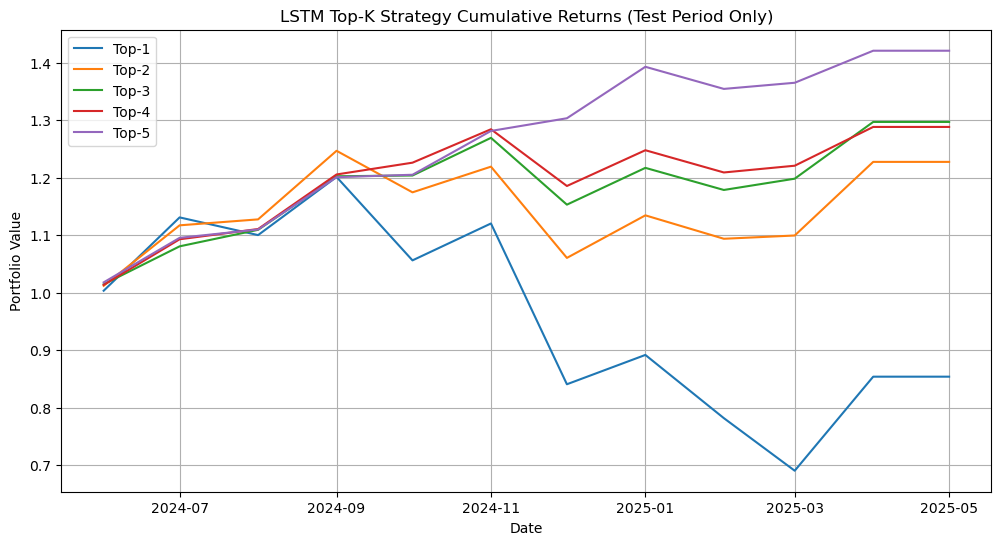

In [4]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

# Load and merge all LSTM prediction CSVs
files = glob.glob("*_lstm_pred.csv")
all_preds = []

for f in files:
    df = pd.read_csv(f, parse_dates=["date"])
    df["stock"] = f.split("_")[0].upper()
    all_preds.append(df)

# Combine into a single DataFrame
preds_df = pd.concat(all_preds)
true_prices = preds_df.pivot(index="date", columns="stock", values="true_close")
predicted_prices = preds_df.pivot(index="date", columns="stock", values="predicted_close")

# Compute expected returns from LSTM predictions
expected_return = (predicted_prices / true_prices) - 1

# Compute realized next-month returns for evaluation
realized_return = true_prices.pct_change().shift(-1)
# Define test period (same logic as during modeling)
test_start = pd.to_datetime(true_prices.index.max()) - pd.DateOffset(years=1)
expected_return_test = expected_return[expected_return.index >= test_start]
realized_return_test = realized_return[realized_return.index >= test_start]

# Simulate Top-K strategies on test set only
portfolio_returns = {}

for k in range(1, 6):  # Top-1 to Top-5
    returns = []

    for date in expected_return_test.index:
        pred_r = expected_return_test.loc[date].dropna()
        real_r = realized_return_test.loc[date].dropna()

        if pred_r.empty or real_r.empty:
            returns.append(0)
            continue

        top_stocks = pred_r.sort_values(ascending=False).head(k).index
        weights = np.repeat(1/k, k)

        actuals = real_r[top_stocks].dropna()
        if len(actuals) == k:
            returns.append(np.dot(weights, actuals))
        else:
            returns.append(0)

    portfolio_returns[f"Top-{k}"] = returns

# Build DataFrame of cumulative returns
returns_df = pd.DataFrame(portfolio_returns, index=expected_return_test.index).fillna(0)
cumulative_df = (1 + returns_df).cumprod()

# Plot
plt.figure(figsize=(12, 6))
for k in cumulative_df.columns:
    plt.plot(cumulative_df.index, cumulative_df[k], label=k)
plt.title("LSTM Top-K Strategy Cumulative Returns (Test Period Only)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()
